# Calculate Effective Exposure Time Metric on DECam Data

by Peter Ferguson & Alex Drlica-Wagner

The goal of this notebook is to use outputs from the LSST Science Pipelines to calculate an equivalent to the DES effective exposure time scale factor, $t_{\rm eff}$ (also called "$\tau$"), described in [Neilsen et al. 2016](https://www.osti.gov/biblio/1250877/). The $t_{\rm eff}$ metric can be calculated for each exposure to yield the equivalent "effective exposure time" needed in nominal conditions to achieve the same signal to noise for point sources. It has also been shown (e.g., [Neilsen et al. 2016](https://www.osti.gov/biblio/1250877/)) that the achieved magnitude limit for point sources scales as ${\rm m}_{\rm lim, obs} = {\rm m}_{\rm lim, 0} + 1.25 \log_{10} (t_{\rm eff})$. The $t_{\rm eff}$ metric has proven to be an extremely useful tool for quickly analyzing the quality of observations both during observing and for selecting exposures as input to yearly processing campaigns. 

Calculating the $t_{\rm eff}$ metric involves comparing the achieved PSF, sky brightness, and transparency (e.g., the extinction due to clouds) to fiducial values for the instrument.  Following Neilsen et al., we define the effective exposure time ratio $\tau$, in terms of a canonical set of conditions: 
(1) the cloudless transparency, $\eta = 1$,
(2) nominal PSF FWHM characteristic of the median i-band zenith, FWHM $= 0.9$ arcsec for DECam at CTIO,
(3) sky brightness representative of zenith dark sky, $b_{\rm dark}$. 
The resulting combination is:

$ t_{\rm eff} = \eta^2 \times \left( \frac{\rm FWHM}{0.9"} \right)^{-2} \times \left( \frac{b}{b_{\rm dark}} \right)^{-1} = c_{\rm eff} \times f_{\rm eff} \times b_{\rm eff}$,

where we have followed the DES convention of defining three terms ($c_{\rm eff}$, $f_{\rm eff}$, and $b_{\rm eff}$) representing the independent affects of clouds, the PSF FWHM, and sky brightness on the derived value of $t_{\rm eff}$.

The purpose of this notebook is to re-implement the DESDM $t_{\rm eff}$ calculation using the outputs of the LSST Science Pipelines. The hope is that this will allow us to implement an equivalement metric for LATISS and eventually LSSTCam. We follow the DESDM calculation of $t_{\rm eff}$ in [assess_SE_products.py](https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py), which includes some fudge factors to match the mountain top quality control (QC) implementation of the same metric.


In [1]:
# Basic imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import fitsio
import lsst.daf.butler as dafButler
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

color_dict={"g": "tab:green", "r":"tab:red", "i":"tab:purple"}

# Calibration Constants and Fudge Factors

These are calibration terms coming from DECam that are defined in [assess_SE_products.py](https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py). Some are converted to panda Series to facilitate joining.

In [2]:
#https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py
pixel_scale= 0.263 # arcsec/pix
magzero = 25 # magnitude zeropoint of 1s exposure

# Constants for PSF and F_EFF
kolmogorov={'u':1.2,'g':1.103,'r':1.041,'i':1.00,'z':0.965,'Y':0.95,'VR':1.04,'N964':0.965}
seeing_fid={}
for band in ['u','g','r','i','z','Y','VR','N964']:
     seeing_fid[band]=0.9*kolmogorov[band]
# For fast indexing
seeing_term = pd.Series(seeing_fid.values(),index=seeing_fid.keys())

# fwhm_DMtoQC_offset was an empirical offset when using FWHM_WORLD
fwhm_DMtoQC_offset_world=1.10
# An additive offset needed when comparing FWHM_MEAN (from PSFex) with respect to QC
fwhm_DMtoQC_offset_psfex=+0.04

#Sky brightness limits from Eric Nielson which were derived "...from a few 
#exposures from a photometric night in SV with little moon (20121215)"
#sbrite_good and sbrite_lim are defined in cts/sec
sbrite_good={"u":0.2,"g":1.05,"r":2.66,"i":7.87,"z":16.51,"Y":14.56,"VR":3.71,"N964":0.4}
sbrite_good = pd.Series(sbrite_good.values(), index=sbrite_good.keys())

These are some fudge factors that are needed to match the LSST Science Pipelines output to the DESDM values. These may or may not be understood at a deeper level, and may or may not be needed for other instruments...

In [3]:
# Fudge factors to go from LSST Pipelines to DESDM output.
# Some are understood and some are not...
# These will likely need to be tuned for each instrument to match teff with maglim.

# PSF fudge factors
psf_add_fudge = fwhm_DMtoQC_offset_psfex # Additive psf fudge factor (see above)
psf_mult_fudge = 1/1.1 # PSF multiplicative fudge factor; may be related to 1/fwhm_DMtoQC_offset_world

# Zeropoint fudge factor
magzero_add_fudge = 0.2 # Used to match DESDM magdiffs
magzero_mult_fudge = 0.0 # Maybe we'll need it

# Sky brightness fudge factors
skybg_add_fudge = 0.0 # Maybe we'll need it
skybg_mult_fudge = 1/1.032 # Maybe related to gain?

# LSST Science Pipelines Data

Query visit information from LSST Science Pipelines. We use the HiTS dataset processed with the "AP with Fakes" pipeline as described in [DM-37694](https://jira.lsstcorp.org/browse/DM-37694).

In [4]:
# Create the butler
repo="/repo/main"
butler = dafButler.Butler(repo)
registry=butler.registry
allcollections=sorted(registry.queryCollections())
butler = dafButler.Butler(repo, collections=allcollections)
registry=butler.registry

# DECam data associated with HiTS
cosmos_refs=sorted(registry.queryDatasets('visitSummary', 
                                    where="instrument='DECam'", 
                                    #findFirst=True
                                    collections=['u/elhoward/DM-37694/hits2015']
                                  ))

## Some other data sets...

## DECam data associated with Saha Galactic Bulge survey
#bulge_refs=sorted(registry.queryDatasets('visitSummary', 
#                                    where="instrument='DECam'", 
#                                    #findFirst=True
#                                    collections=['u/kherner/PREOPS-597_20220120']
#                                  ))

## DECam data associated with HiTS
#old_cosmos_refs=sorted(registry.queryDatasets('visitSummary', 
#                                    where="instrument='DECam'", 
#                                    #findFirst=True
#                                    collections=['u/elhoward/DM-36024/templates/20221003T224447Z']
#                                  ))

In [5]:
def query_summary_table(butler, visitSummaryRefList):
    """ Query the VisitSummary table for information that goes into the t_eff calcuation.
    
    Parameters
    ----------
    butler : the butler instance
    refs   : the dataset refs that have been queried
    
    Returns
    -------
    frame  : data frame of summary quantities
    """
    # Get the data set refs

    summaryFrame=[]
    tbl=butler.get(visitSummaryRefList[0]).asAstropy()
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    for visitSummaryRef in tqdm(visitSummaryRefList):
        table=butler.get(visitSummaryRef).asAstropy()[names].to_pandas()
        
        visitSummary = butler.get(visitSummaryRef)
        visitInfo = visitSummary[0].getVisitInfo()
        
        table["airmass"]=visitInfo.boresightAirmass
        table["exposureTime"]=visitInfo.exposureTime
        summaryFrame.append(table)
    summaryFrame=pd.concat(summaryFrame)
    return summaryFrame

In [6]:
# Check if data exists already...

#datafile = 'saha_bulge_summary.csv'
#refs = bulge_refs

datafile = 'hits_cosmos_summary.csv'
refs = cosmos_refs

if os.path.exists(datafile):
    print(f"Loading summary table from {datafile}...")
    summaryFrame = pd.read_csv(datafile)
else:
    print("Querying summary table...")
    summaryFrame = query_summary_table(butler, refs)
    summaryFrame.to_csv(datafile, index=False)

Loading summary table from hits_cosmos_summary.csv...


In [7]:
summaryFrame.columns

Index(['id', 'bbox_min_x', 'bbox_min_y', 'bbox_max_x', 'bbox_max_y', 'visit',
       'physical_filter', 'band', 'psfSigma', 'psfArea', 'psfIxx', 'psfIyy',
       'psfIxy', 'ra', 'decl', 'zenithDistance', 'zeroPoint', 'skyBg',
       'skyNoise', 'meanVar', 'astromOffsetMean', 'astromOffsetStd',
       'nPsfStar', 'psfStarDeltaE1Median', 'psfStarDeltaE2Median',
       'psfStarDeltaE1Scatter', 'psfStarDeltaE2Scatter',
       'psfStarDeltaSizeMedian', 'psfStarDeltaSizeScatter',
       'psfStarScaledDeltaSizeScatter', 'airmass', 'exposureTime'],
      dtype='object')

# DESDM Data

Load the DESDM data for calibration/comparison. This data comes from a query like...

```SQL
select q.*, e.telra, e.teldec, e.nite, e.band, e.exptime 
from qa_summary q, exposure e 
where e.expnum = q.expnum and e.expnum between 288928 and 421607
order by e.expnum
```

The exposure range was determined from the DECam exposures that were processed by LSST and accessed above.

In [8]:
# Load DESDM metadata
desdm_filename = 'decade_teff.csv'
if not os.path.exists(desdm_filename):
    !wget https://data.darkenergysurvey.org/fnalmisc/delve/data/{desdm_filename}
desFrame=pd.read_csv(desdm_filename)
desFrame.columns

Index(['EXPNUM', 'PFW_ATTEMPT_ID', 'SOURCE', 'T_EFF', 'PSF_FWHM', 'F_EFF',
       'SKYBRIGHTNESS', 'B_EFF', 'CLOUD_APASS', 'CLOUD_NOMAD', 'N_APASS',
       'N_NOMAD', 'C_EFF', 'SKYTILT', 'ASTROM_SIGMA', 'ASTROM_OFFSET',
       'ASTROM_NDETS', 'ASTROM_CHI2', 'NOBJECTS', 'FLAG', 'CALNAC',
       'CLOUD_DES', 'N_DES', 'TELRA', 'TELDEC', 'NITE', 'BAND', 'EXPTIME'],
      dtype='object')

In [9]:
# Merge the two frames
mergeFrame=summaryFrame.merge(how='left', right=desFrame, left_on='visit', right_on='EXPNUM')
mergeFrame=mergeFrame.loc[~np.isnan(mergeFrame["PSF_FWHM"])]

grpFrame = mergeFrame.groupby('visit')
grpBand  = np.concatenate(grpFrame['band'].unique().values)

print(f"Found {len(grpBand)} matched exposures...")

Found 50 matched exposures...


In [10]:
def plot_comparison(x, y, xmean, ymean, xlabel='x', ylabel='y'):
    """ Utility function for plotting comparisons between two quantities 
    and their grouped means.
    
    Parameters
    ----------
    x : first value
    y : second value
    xmean : grouped mean of first value
    ymean : grouped mean of second value
    xlabel : x-axis label
    ylabel : y-axis label
    
    Returns
    -------
    fig, ax : figure and axis   
    """
    fig,ax = plt.subplots(2,1,sharex=True,figsize=(8,6))
    plt.subplots_adjust(hspace=0.0)
    ax[0].hist2d(x, y, bins=100, norm=LogNorm())
    ax[0].plot(xmean, ymean, 'ok')
    ax[0].plot([-1,10],[-1,10], c="r")

    ax[1].plot(xmean, ymean - xmean, 'ok')
    ax[1].axhline(0, c='r')
    ax[0].set_ylabel(ylabel)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel("Residual")
    return fig, ax

## PSF Metric

The PSF component of $t_{\rm eff}$ is commonly referred to as $f_{\rm eff}$. It is generally defined as the square of the achieved seeing relative to some fiducial value. In the case of DES, this fiducial value is calculated from the median i-band zenith value (0.9 arcsec) converted to the observed band using the central wavelengths of each band and assuming a Kolmogorov turbulence spectrum.

In [11]:
# PSF Transformation
def psf_sigma_to_psf_fwhm(psfSigma):
    """ Transform LSST psfSigma to DESDM PSF_FWHM.
    
    Parameters
    ----------
    psfSigma : psfSigma value from LSST [pixels]
    
    Returns
    -------
    psf_fwhm : PSF_FWHM value from DESDM [arcsec]
    """
    sigma2fwhm = 2.355 # Convert from Gaussian sigma to fwhm
    psf_fwhm = psfSigma * sigma2fwhm * pixel_scale * psf_mult_fudge
    return psf_fwhm

def lsst_feff(psfSigma, band):
    """ Calculate F_EFF value from LSST psfSigma.
    
    Parameters
    ----------
    psfSigma : standard deviation of the PSF [pixels]
    band     : band for observation
    
    Returns
    -------
    f_eff : PSF effective exposure time scale factor
    """
    # Convert to 
    psf_fwhm = psf_sigma_to_psf_fwhm(psfSigma)
    # DESDM fudge factor to match DECam QC tools
    fwhm_use = psf_fwhm + psf_add_fudge
    # Band dependent fiducial seeing fwhm value [arcsec]
    fwhm_fid = seeing_term[band].values
    # Effective exposure time scale factor
    f_eff = (fwhm_use / fwhm_fid)**-2

    return f_eff

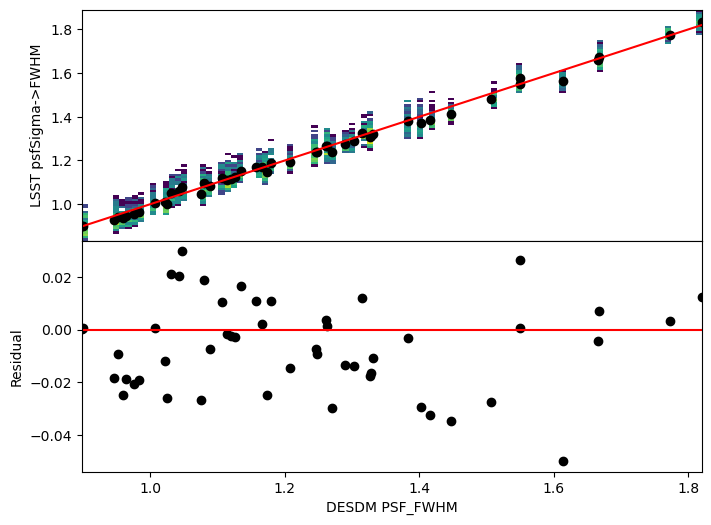

In [12]:
fig, ax = plot_comparison(mergeFrame["PSF_FWHM"], psf_sigma_to_psf_fwhm(mergeFrame["psfSigma"]),
                          grpFrame["PSF_FWHM"].mean(), psf_sigma_to_psf_fwhm(grpFrame["psfSigma"].mean()),
                          xlabel='DESDM PSF_FWHM', ylabel='LSST psfSigma->FWHM')

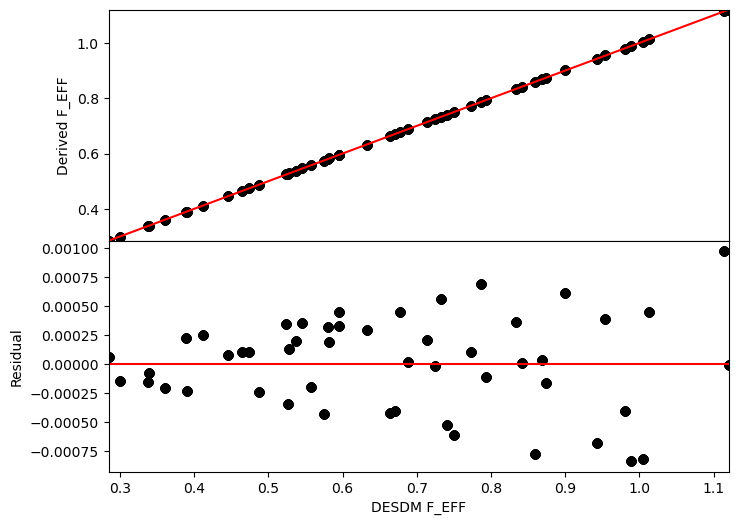

In [13]:
# Verify that we can transform from PSF_FWHM to F_EFF
# https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py#L1798
f_eff = (seeing_term[mergeFrame['band']].values / (mergeFrame["PSF_FWHM"] + psf_add_fudge))**2

fig, ax = plot_comparison(mergeFrame["F_EFF"], f_eff,
                          mergeFrame["F_EFF"], f_eff,
                          xlabel='DESDM F_EFF', ylabel='Derived F_EFF')

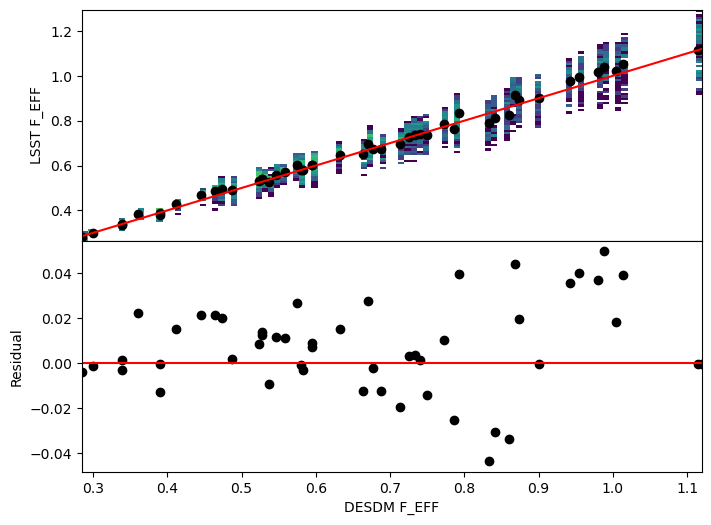

In [14]:
# Derive LSST F_EFF

fig, ax = plot_comparison(mergeFrame["F_EFF"], lsst_feff(mergeFrame["psfSigma"], mergeFrame['band']),
                          grpFrame["F_EFF"].mean(), lsst_feff(grpFrame["psfSigma"].mean(),grpBand),
                          xlabel='DESDM F_EFF', ylabel='LSST F_EFF')

## Transparency Metric

The transparency (referred to in DES as the "cloud" value) is contained in the $c_{\rm eff}$ term. This is calculated from the difference between the observed and catalog magnitude of sources in a reference catalog (DES started out using APASS, which is not recemmonded). All the hard work behind this function (i.e., coming up with transformation to the reference catalog, doing the matching, selecting reasonable objects to compare, rejecting outliers, etc.) is done upstream. The transparency is thus defined as:
$\eta = f_{\rm obs}/f_0$. The effective transparency correction is thus

$c_{\rm eff} = \eta^2 = \left( \frac{f_{\rm obs}}{f_0} \right)^2 = 10^{ -2({\rm mag}_{\rm obs} - {\rm mag}_0)/2.5} $

The DES implementation modifies this definition in two slightly odd ways:
1. DES clips $c_{\rm eff} \leq 1$, the motivation being that the transparency can never be > 100%
2. An extra fudge factor of 0.2 mag is applied to calculate the magnitude differences and then removed in the c_eff calculation.


In [15]:
# Calculate magdiff 
def zeropoint_to_magdiff(zeropoint, exptime, band=None, airmass=None):
    """ Convert from the zeropoint to a magnitude difference relative to reference catalog.
    
    Parameters
    ----------
    zeropoint : magnitude zeropoint
    exptime   : exposure time [seconds]
    band      : observation band
    airmass   : airmass of observation

    Returns
    -------
    magdiff : magnitude difference
    """
    # This fudge factor gets removed in lsst_ceff, but is needed to get magdiff to match DESDM.
    magzero = 25.0 + magzero_add_fudge
    magzero += 2.5*np.log10(exptime) # correct for exposure time

    # K-term correction
    if airmass is not None and band is not None:
        kcorr = kterm[band].values * airmass
    else:
        kcorr = 0
    magdiff = magzero - (zeropoint +  kcorr)
    return magdiff

def lsst_ceff(zeropoint, exptime, band=None, airmass=None, clip=True):
    """ Calculate C_EFF value from LSST zeropoint and exposure time
    
    Parameters
    ----------
    zeropoint : magnitude zeropoint
    exptime   : exposure time [seconds]
    band      : observation band
    airmass   : airmass of observation
    clip      : if c_eff > 1: c_eff = 1 
    
    Returns
    -------
    c_eff     : transparency effective exposure time scale factor
    """
    magdiff = zeropoint_to_magdiff(zeropoint, exptime, band, airmass)
    c_eff=10**(-2.0*(magdiff - magzero_add_fudge)/2.5)
    if clip: c_eff[c_eff > 1.0] = 1.0
    return c_eff

Text(0.5, 0, 'DESDM C_EFF')

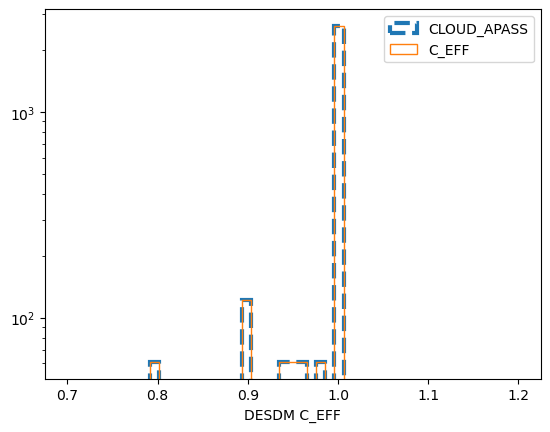

In [16]:
# Check that C_EFF comes from CLOUD_APASS values
# https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py#L1818
c_eff=10**(-2*(mergeFrame["CLOUD_APASS"]-0.2)/2.5)
c_eff[c_eff > 1]=1

bins=np.linspace(0.7,1.2)
plt.hist(c_eff, bins=bins, histtype="step", ls='--',lw=3, label='CLOUD_APASS')
plt.hist(mergeFrame["C_EFF"], bins=bins, histtype="step", label='C_EFF', log=True) 
plt.legend()
plt.xlabel('DESDM C_EFF')

Text(0, 0.5, 'LSST MAGDIFF')

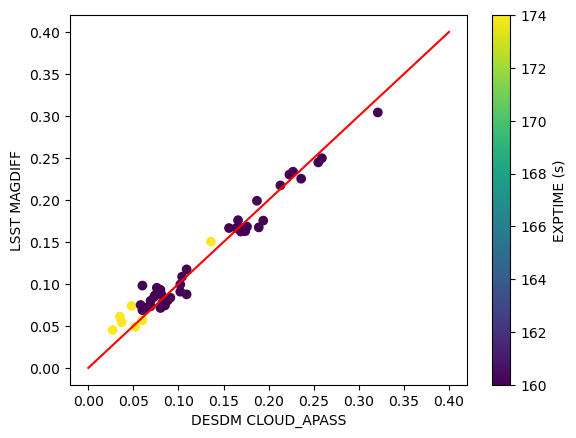

In [17]:
# We need to be sure to account for exposure time.
magdiff = zeropoint_to_magdiff(mergeFrame["zeroPoint"],mergeFrame['EXPTIME'])
magdiff_grp = zeropoint_to_magdiff(grpFrame["zeroPoint"].mean(), grpFrame['EXPTIME'].mean())

plt.scatter(grpFrame['CLOUD_APASS'].mean(), magdiff_grp, c=grpFrame['EXPTIME'].mean())
plt.colorbar(label='EXPTIME (s)')
plt.plot([0,0.4],[0,0.4],c='r')
plt.xlabel('DESDM CLOUD_APASS')
plt.ylabel('LSST MAGDIFF')

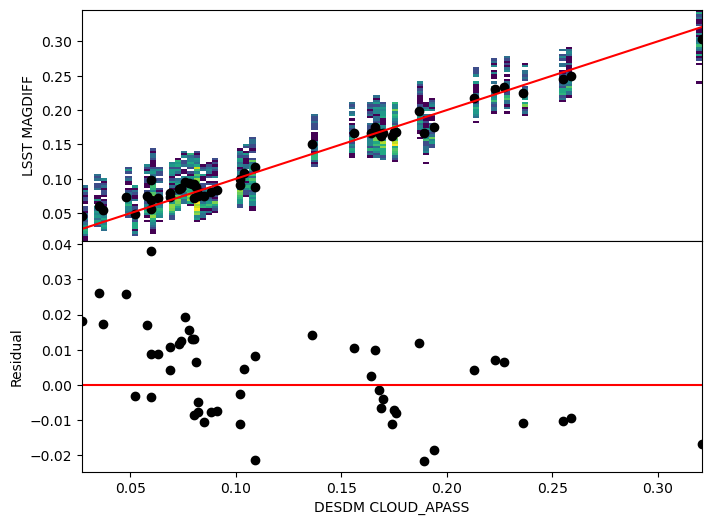

In [18]:
fig, ax = plot_comparison(mergeFrame['CLOUD_APASS'], magdiff,
                          grpFrame['CLOUD_APASS'].mean(), magdiff_grp,
                          xlabel='DESDM CLOUD_APASS', ylabel='LSST MAGDIFF')

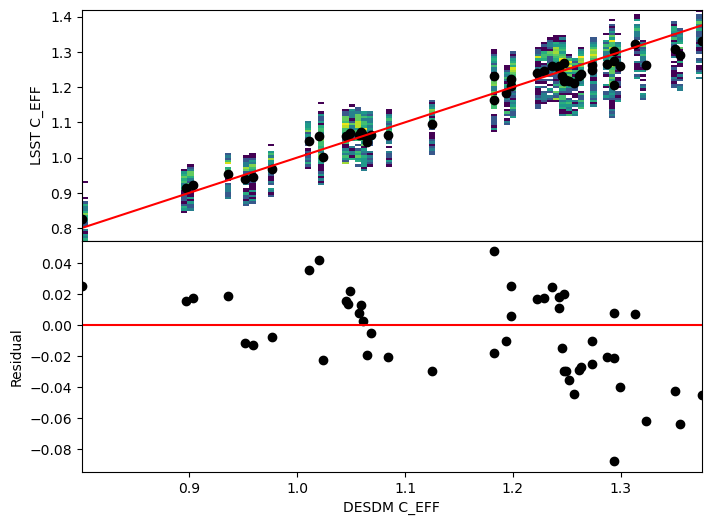

In [19]:
# Calculate DESDM C_EFF without clipping
c_eff = 10**(-2*(mergeFrame["CLOUD_APASS"]-0.2)/2.5)
c_eff_grp = 10**(-2*(grpFrame["CLOUD_APASS"].mean()-0.2)/2.5)

fig, ax = plot_comparison(c_eff, lsst_ceff(mergeFrame["zeroPoint"], mergeFrame['EXPTIME'], clip=False),
                          c_eff_grp, lsst_ceff(grpFrame["zeroPoint"].mean(), grpFrame['EXPTIME'].mean(), clip=False),
                          xlabel='DESDM C_EFF', ylabel='LSST C_EFF')

## Sky Brightness Metric

The sky brightness term, $b_{\rm eff}$, is calculated from the ratio between the observed sky brightness and a fiducial, dark-sky value in each band. For DES, these fiducial values were determined early in the survey when the processed images were in units of DN/s, leading to some interesting conversion hoops.

In [20]:
# There are a few columns that could be related to skybrightness
print(mergeFrame.columns)
mergeFrame[['SKYBRIGHTNESS','meanVar','skyBg', 'skyNoise']]

Index(['id', 'bbox_min_x', 'bbox_min_y', 'bbox_max_x', 'bbox_max_y', 'visit',
       'physical_filter', 'band', 'psfSigma', 'psfArea', 'psfIxx', 'psfIyy',
       'psfIxy', 'ra', 'decl', 'zenithDistance', 'zeroPoint', 'skyBg',
       'skyNoise', 'meanVar', 'astromOffsetMean', 'astromOffsetStd',
       'nPsfStar', 'psfStarDeltaE1Median', 'psfStarDeltaE2Median',
       'psfStarDeltaE1Scatter', 'psfStarDeltaE2Scatter',
       'psfStarDeltaSizeMedian', 'psfStarDeltaSizeScatter',
       'psfStarScaledDeltaSizeScatter', 'airmass', 'exposureTime', 'EXPNUM',
       'PFW_ATTEMPT_ID', 'SOURCE', 'T_EFF', 'PSF_FWHM', 'F_EFF',
       'SKYBRIGHTNESS', 'B_EFF', 'CLOUD_APASS', 'CLOUD_NOMAD', 'N_APASS',
       'N_NOMAD', 'C_EFF', 'SKYTILT', 'ASTROM_SIGMA', 'ASTROM_OFFSET',
       'ASTROM_NDETS', 'ASTROM_CHI2', 'NOBJECTS', 'FLAG', 'CALNAC',
       'CLOUD_DES', 'N_DES', 'TELRA', 'TELDEC', 'NITE', 'BAND', 'EXPTIME'],
      dtype='object')


,SKYBRIGHTNESS,meanVar,skyBg,skyNoise
1,1.64,66.505250,292.14252,8.268493
2,1.59,64.235950,281.77097,8.176215
3,1.44,58.392487,255.78865,7.768799
4,1.36,55.468340,242.45139,7.584558
5,1.32,53.550540,233.69008,7.503772
...,...,...,...,...
3472,1.54,67.124450,252.63170,8.292872
3473,1.54,73.344570,250.28346,8.678988
3474,1.54,68.667530,251.58134,8.387182
3475,1.54,77.752270,251.56569,8.893423


From the annals of the DES Slack, I once asked what SKYBRIGHTNESS really was... Robert responded that SKYBRIGHTNESS is in DN/s because the original fiducials developed in DES SV and early DES Y1 were in DN/s, so when we moved to the new reduction codes the calculation had to be reverse engineered to match (and values of DN/s were kept for backward compatibility). The difference between this and other SKYBRITE values should be 360 for survey exposures (since the global average for the gains is 4 and the exposure time is 90s).

In [21]:
def skybg_to_skybright(skybg, exptime):
    """ Convert LSST sky background to DESDM sky background.
    
    Parameters
    ----------
    skybg   : LSST sky background value [counts]
    exptime : exposure time [seconds]
    
    Returns
    -------
    skybright : DESDM skybright value [DN/s]
    """
    sky_fudge = skybg_mult_fudge # Why? Gain?
    skybright = skybg/exptime * sky_fudge
    return skybright

def lsst_beff(skybg, exptime, band):
    """ Calculate B_EFF value from LSST sky background and exposure time.
    
    Parameters
    ----------
    skybg   : LSST sky background value [counts]
    exptime : exposure time [seconds]
    band    : observation band
    
    Returns
    -------
    b_eff     : transparency effective exposure time scale factor

    """ 
    skybright = skybg_to_skybright(skybg, exptime)
    b_eff = sbrite_good[band].values/skybright
    return b_eff

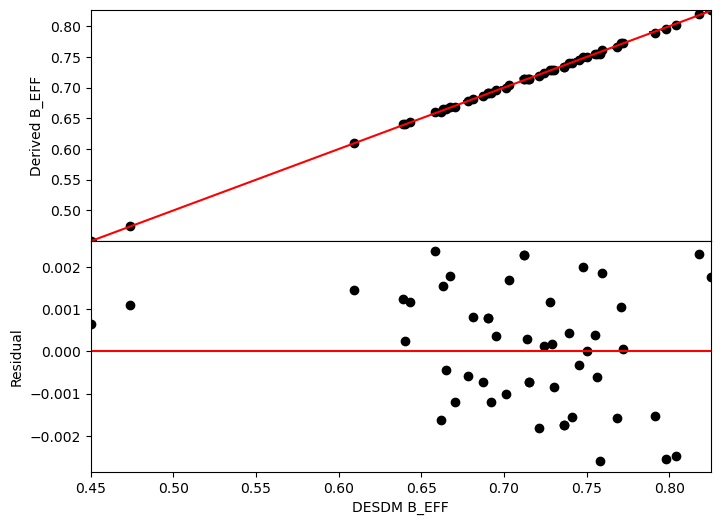

In [22]:
# Check that we can reproduce the B_EFF calculation
#https://github.com/DarkEnergySurvey/qatoolkit/blob/main/bin/assess_SE_products.py#L1810
b_eff = sbrite_good[mergeFrame['band']].values/mergeFrame['SKYBRIGHTNESS']
b_eff_grp = sbrite_good[grpBand].values/grpFrame['SKYBRIGHTNESS'].mean()

fig, ax = plot_comparison(mergeFrame['B_EFF'], b_eff,
                          grpFrame['B_EFF'].mean(), b_eff_grp,
                          xlabel='DESDM B_EFF', ylabel='Derived B_EFF')

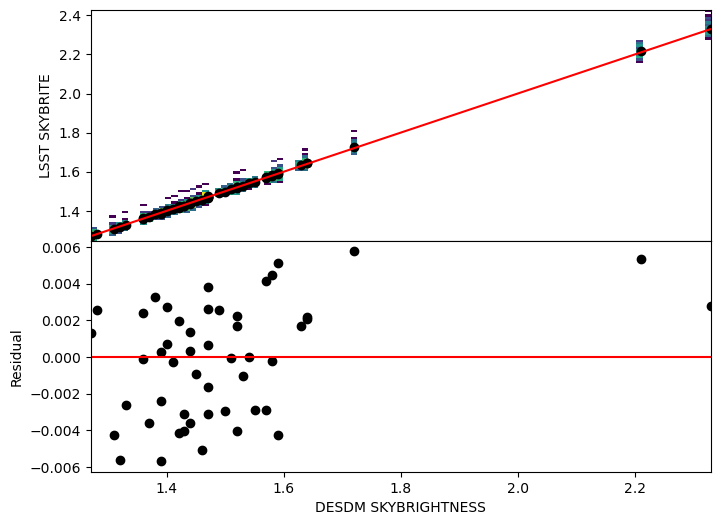

In [23]:
# Check that we can derive LSST sky brightness
sky = skybg_to_skybright(mergeFrame["skyBg"], mergeFrame["exposureTime"])
sky_grp = skybg_to_skybright(grpFrame["skyBg"].mean(), grpFrame["exposureTime"].mean())

fig, ax = plot_comparison(mergeFrame['SKYBRIGHTNESS'], sky,
                          grpFrame['SKYBRIGHTNESS'].mean(), sky_grp,
                          xlabel='DESDM SKYBRIGHTNESS', ylabel='LSST SKYBRITE')

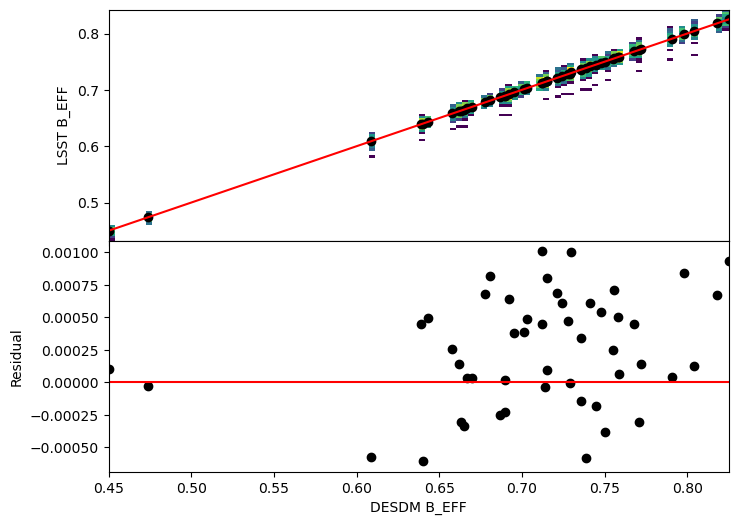

In [24]:
fig, ax = plot_comparison(mergeFrame['B_EFF'], lsst_beff(mergeFrame["skyBg"], mergeFrame['exposureTime'], mergeFrame['band']),
                          grpFrame['B_EFF'].mean(), lsst_beff(grpFrame["skyBg"].mean(), grpFrame['exposureTime'].mean(), grpBand),
                          xlabel='DESDM B_EFF', ylabel='LSST B_EFF')

## Effictive Exposure Time Scale Factor

Putting it all together, we can calculate $t_{\rm eff} = f_{\rm eff} \times c_{\rm eff} \times b_{\rm eff}$. To reproduce what is being done in DES, we clip $c_{\rm eff} \leq 1.0$ (transparency can't be greater than 100%). The fact that we get pretty good agreement for all quantities is not completely trivial, since the processing is quite different.

In [25]:
def lsst_teff(psfSigma, zeroPoint, skyBg, expTime, band):
    """ Calculate the effective exposure time scale factor from DES.
    
    Parameters
    ----------
    psfSigma  : Standard deviation of the PSF (pixels)
    zeroPoint : Zero point derived from reference catalog (mag)
    exptime   : Exposure time (seconds)
    band      : Short name for filter band
    
    Returns
    -------
    struct : Dictionary containing t_eff, f_eff, c_eff, b_eff
    """

    # PSF component
    f_eff = lsst_feff(psfSigma, band)
    # Transparency component
    c_eff = lsst_ceff(zeroPoint, expTime, clip=True)
    # Sky brightness component
    b_eff = lsst_beff(skyBg, expTime, band=band)
    # Effective exposure time scale factor
    t_eff = f_eff * c_eff * b_eff
    
    struct = dict(t_eff=t_eff, f_eff=f_eff, c_eff=c_eff, b_eff = b_eff)
    return struct

In [26]:
# Evaluate t_eff, etc.
teffMerge = lsst_teff(mergeFrame['psfSigma'], mergeFrame['zeroPoint'], mergeFrame['skyBg'], mergeFrame['exposureTime'], mergeFrame['band'])
teffGrp = lsst_teff(grpFrame['psfSigma'].mean(), grpFrame['zeroPoint'].mean(), grpFrame['skyBg'].mean(), grpFrame['exposureTime'].mean(), grpBand)

Text(0.5, 1.0, 'Effective Exposure Time Scale Factor')

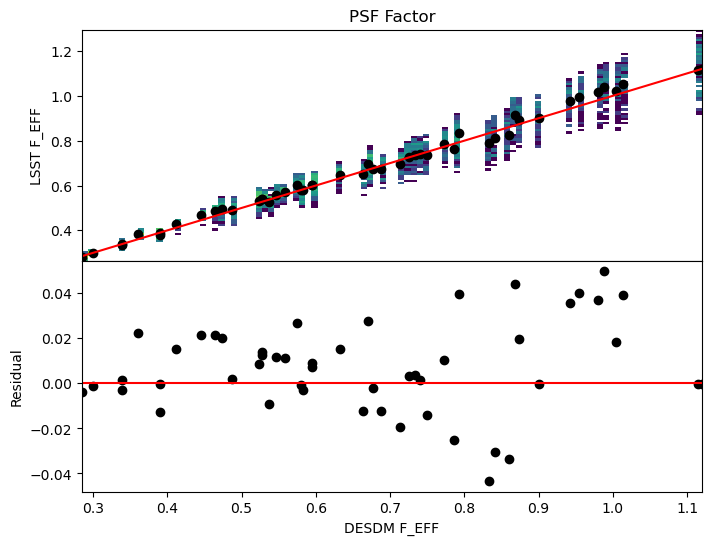

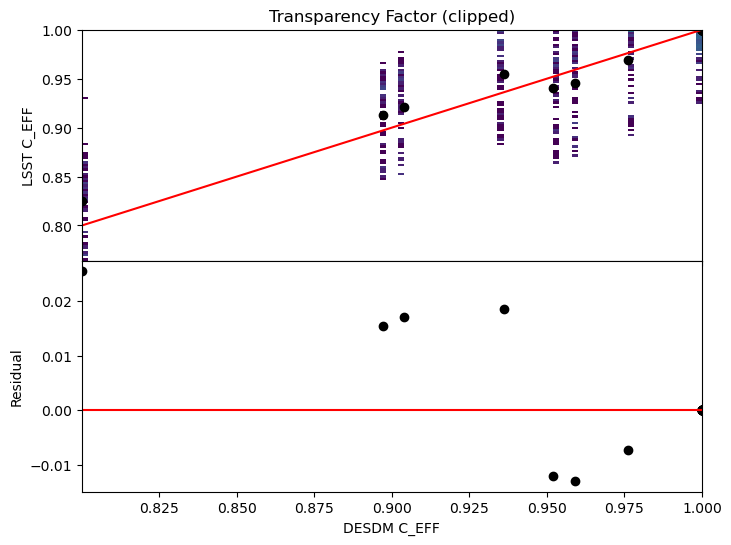

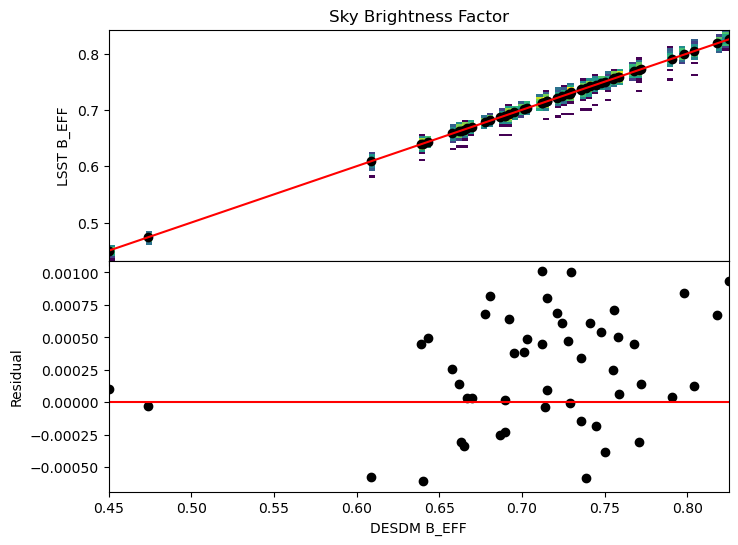

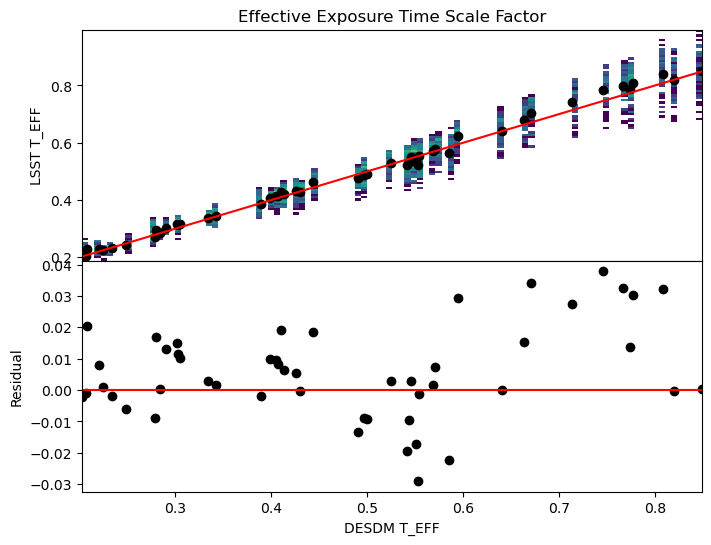

In [27]:
# Plot t_eff, etc...
# Seeing
fig, ax = plot_comparison(mergeFrame["F_EFF"], teffMerge['f_eff'], 
                          grpFrame["F_EFF"].mean(), teffGrp['f_eff'],
                          xlabel='DESDM F_EFF', ylabel='LSST F_EFF')
ax[0].set_title("PSF Factor")

# Transparency
fig, ax = plot_comparison(mergeFrame["C_EFF"], teffMerge['c_eff'], 
                          grpFrame["C_EFF"].mean(), teffGrp['c_eff'],
                          xlabel='DESDM C_EFF', ylabel='LSST C_EFF')
ax[0].set_title("Transparency Factor (clipped)")

# Sky brightness
fig, ax = plot_comparison(mergeFrame["B_EFF"], teffMerge['b_eff'], 
                          grpFrame["B_EFF"].mean(), teffGrp['b_eff'],
                          xlabel='DESDM B_EFF', ylabel='LSST B_EFF')
ax[0].set_title("Sky Brightness Factor")

# Total effective exposure time factor
fig, ax = plot_comparison(mergeFrame["T_EFF"], teffMerge['t_eff'], 
                          grpFrame["T_EFF"].mean(), teffGrp['t_eff'],
                          xlabel='DESDM T_EFF', ylabel='LSST T_EFF')
ax[0].set_title("Effective Exposure Time Scale Factor")